In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 12
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((470, 12, 1), (470,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT12/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 15s 228ms/step - loss: 0.1699 - root_mean_squared_error: 0.4122 - val_loss: 0.0712 - val_root_mean_squared_error: 0.2669
Epoch 2/50
48/48 [==============================] - 8s 173ms/step - loss: 0.1365 - root_mean_squared_error: 0.3694 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2143
Epoch 3/50
48/48 [==============================] - 11s 224ms/step - loss: 0.0750 - root_mean_squared_error: 0.2739 - val_loss: 0.0437 - val_root_mean_squared_error: 0.2090
Epoch 4/50
48/48 [==============================] - 11s 241ms/step - loss: 0.0601 - root_mean_squared_error: 0.2452 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1912
Epoch 5/50
48/48 [==============================] - 11s 228ms/step - loss: 0.0487 - root_mean_squared_error: 0.2208 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1822
Epoch 6/50
48/48 [==============================] - 8s 171ms/step - loss: 0.0386 - root_mean_squared_error: 0.1965 - val_loss: 0.0261 - 

48/48 [==============================] - 1s 19ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1853
Epoch 40/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0329 - val_root_mean_squared_error: 0.1814
Epoch 41/50
48/48 [==============================] - 1s 19ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1779
Epoch 42/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1747
Epoch 43/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1738
Epoch 44/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0393 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

2.134323310852051 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

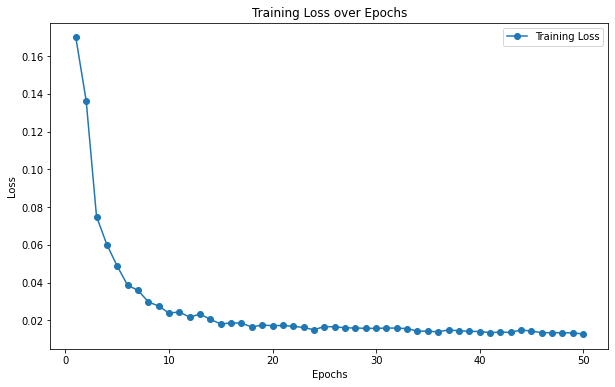

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

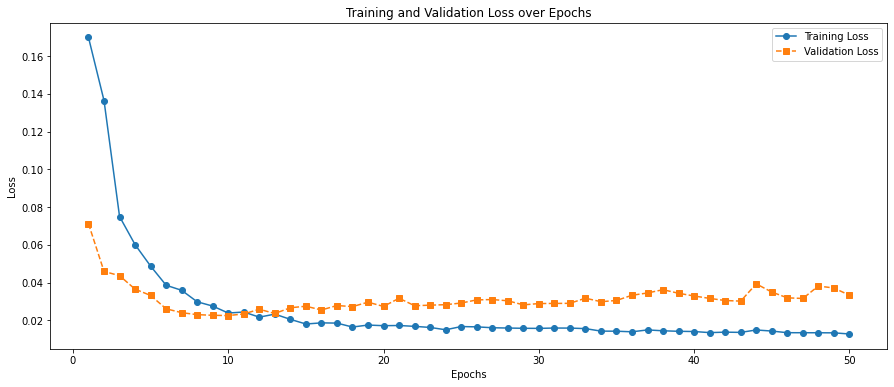

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT12/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 8ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.14892658775638656
MAE : 0.11463884061379764


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,37701.011719,236263.303
1,26368.865234,43422.368
2,37157.304688,2161.744
3,56057.000000,944.181
4,86743.937500,13977.643
5,132695.687500,24795.001
6,197833.312500,168828.990
7,294092.593750,461098.498
8,344348.312500,591635.798
9,212399.937500,598360.298


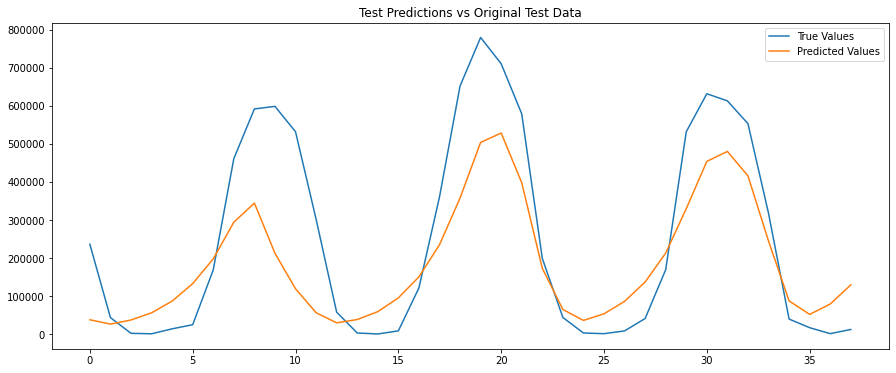

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

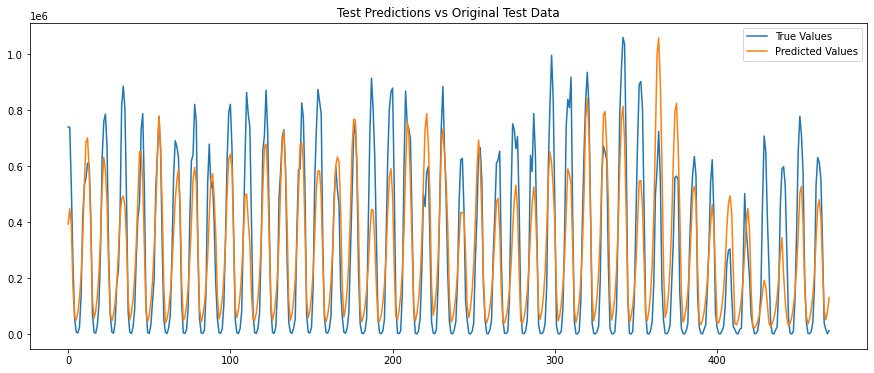

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()